In [76]:
import pandas as pd
import os
from pathlib import Path
from dotenv import load_dotenv
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from IPython.display import HTML
from datetime import date
from sqlalchemy import create_engine

# This library was created to prevent code repetition.
%run ./lib

### Database: 1. Set up a PostgreSQL database with the provided tables.

*a -* in the docker-compose file change the path of the volume to a path in your machine

*b -* in the project path, use the terminal and run: docker-compose up -d

*c -* execute the code below to load the .csv files stored in the folder:  *projeto_cw/data/csv/*

In [77]:
"""
the code below read the csv file, format some columns to datetime and use 2 custom functions to
write the data into the database and to create a primary key into the dim_clients table.
"""

# Load Clients
client_df = load_csv('clients')
client_df['created_at'] = pd.to_datetime(client_df['created_at'], format='%Y-%m-%d %H:%M:%S')
client_df['denied_at'] = pd.to_datetime(client_df['denied_at'], format='%Y-%m-%d %H:%M:%S')


# Load loans
loan_df = load_csv('loans')
loan_df['created_at'] = pd.to_datetime(loan_df['created_at'], format='%Y-%m-%d %H:%M:%S')
loan_df['due_at'] = pd.to_datetime(loan_df['due_at'], format='%Y-%m-%d %H:%M:%S')
loan_df['paid_at'] = pd.to_datetime(loan_df['paid_at'], format='%Y-%m-%d %H:%M:%S')

# Write in the database
write_to_dw(table_name='dim_clients', df=client_df)
write_to_dw(table_name='fact_loans', df=loan_df)

# Define user_id as primary key from dim_clients
create_primary_key('dim_clients', 'user_id')

C:\Users\duani\OneDrive\Github\Projetos\projeto_cw\notebook\lib.py:8: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  return df


dim_clients written successfully!
fact_loans written successfully!


### Database: 2. Explain the relationship between the tables.

There are 2 tables:

-- A dimension table named dim_clients, with the primary key being **user_id**.

-- A fact table named fact_loans with unique ids for loans and a foreign key **user_id** witch belongs to the table dim_clients

### SQL: 1. Identify the best month in terms of loan issuance. What was the quantity and amount lent in each month?

As we can see in the result below, the best month in terms of amount and quantity of loans was december-23

In [78]:
"""
The query below selects the loan table:
-- Convert the data to the format yyyy-mm for summarization
-- Summarize the amount and quantity of loans
-- Create a rank of amount and quantity by month
-- Order the table in descending order by loan amount, so we can see the best month first.
"""

query = """
select
	 to_char(date_trunc('month', created_at), 'yyyy-mm') as create_month
	,sum(loan_amount) as amount
	,count(loan_id) as quantity
	,rank() over (order by sum(loan_amount) desc) as top_amount
	,rank() over (order by count(loan_id) desc) as top_quantity
from public.fact_loans
group by create_month
order by sum(loan_amount) desc
"""
df = read_from_dw_sql(query=query)

# remove .head() to see the entire data.
df.head(5)

,create_month,amount,quantity,top_amount,top_quantity
0,2023-12,442464966,17351,1,1
1,2024-01,409112591,16123,2,2
2,2023-11,330839275,13269,3,3
3,2023-10,293005656,11593,4,4
4,2023-09,229573371,8976,5,5


### SQL: 2. Which batch had the best overall adherence?

As we can see in the result below, the batch with the highest adherence was the batch 1

In [79]:
"""
The query below selects the loan table and join with the client table:
-- Use the batch in the client table to summarize the information
-- Distinct count the user_id with loans to measure the adherence
-- Order the result by number of clients and use limit 1 to return just 1 value
"""

query = """
select
	 c.batch
	,count(distinct l.user_id) as adherence
from fact_loans l
left join dim_clients c
  on l.user_id = c.user_id
group by batch
order by adherence desc
limit 1
"""
df = read_from_dw_sql(query=query)

# remove .head() to see the entire data.
df.head(5)

,batch,adherence
0,1,46172


### SQL: 3. Do different interest rates lead to different loan outcomes in terms of default rate?

We can see in the tables below that the interest rate does not impact the default rate of loans. At the end of this section of the notebook, we can observe in graphical form that there is no strong correlation between these two variables.

In [80]:
"""
-- The query below selects the loan table and joins it with the client table, creating a Common Table Expression (CTE) named 'tb_loans' in the first call.
-- The CTE returns records before 2024-01-25 and creates a column indicating 1 for default loans while calculating the amount of interest.
-- The amount of interest deducts the taxes from the due amount and subtracts it from the loan amount.
-- The result is a table with the interest rate (amount / loan amount) and the default rate (number of defaulted loans / total loans).
"""

query = """
with tb_loans as (
	select
		 to_char(date_trunc('month', l.due_at), 'yyyy-mm') as due_month
		,c.batch
		,case when l.status = 'default' then 1 else 0 end default_loans
		,l.loan_amount as loan_amount
		,l.due_amount - l.tax - l.loan_amount as interest_amount
	from fact_loans l
	left join dim_clients c 
	  on l.user_id = c.user_id
	where l.due_at < '2024-01-25'
)
select
	 due_month
	,round(avg(default_loans) * 100, 2) as default_rate
	,round(cast(sum(interest_amount) / sum(loan_amount) as decimal(15, 4)) * 100, 2) as interest_rate
from tb_loans
group by due_month
order by due_month
"""
month_df = read_from_dw_sql(query=query)

# remove .head() to see the entire data.
month_df.tail(15)

,due_month,default_rate,interest_rate
31,2022-11,11.97,13.29
32,2022-12,12.38,12.93
33,2023-01,11.55,13.10
34,2023-02,12.81,13.22
35,2023-03,12.00,13.11
36,2023-04,10.91,12.99
37,2023-05,12.25,13.01
38,2023-06,12.81,12.94
39,2023-07,12.19,13.32
40,2023-08,12.22,13.25


In [81]:
"""
-- The query below is the same as the previous query; the difference is the summarization by batch instead of by month.
"""

query = """
with tb_loans as (
	select
		 to_char(date_trunc('month', l.due_at), 'yyyy-mm') as due_month
		,c.batch
		,case when l.status = 'default' then 1 else 0 end default_loans
		,l.loan_amount as loan_amount
		,l.due_amount - l.tax - l.loan_amount as interest_amount
	from fact_loans l
	left join dim_clients c 
	  on l.user_id = c.user_id
	where l.due_at < '2024-01-25'
)
select
	 batch
	,round(avg(default_loans) * 100, 2) as default_rate
	,cast(sum(interest_amount) / sum(loan_amount) as decimal(15, 4)) * 100 as interest_rate
from tb_loans
group by batch
order by batch
"""
batch_df = read_from_dw_sql(query=query)
batch_df

,batch,default_rate,interest_rate
0,1,11.95,13.1500
1,2,12.51,13.0700
2,3,11.83,13.0000
3,4,12.49,13.1100


We can see using a scatter plot to evaluate the correlation

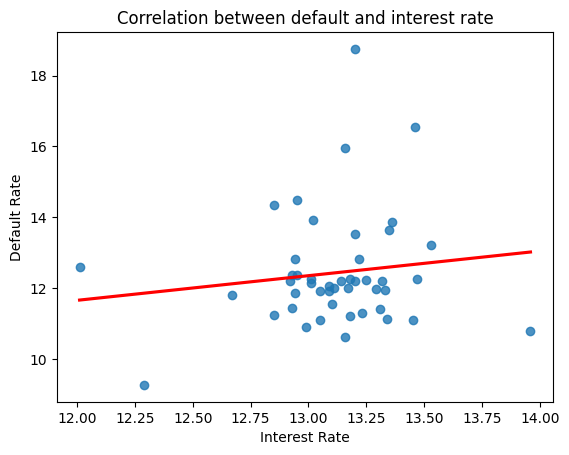

In [82]:
"""
-- This is the code for the graphic visualization of the correlation between interest and default. 
-- The scatter plot illustrates the distribution of the values along with a red regression line, indicating a very weak relationship.
"""

import matplotlib.pyplot as plt
import seaborn as sns


df = month_df[['interest_rate', 'default_rate']].copy()
df['default_rate'] = pd.to_numeric(df['default_rate'])
df['interest_rate'] = pd.to_numeric(df['interest_rate'])

# Scatter plot with regression line
sns.regplot(x='interest_rate', y='default_rate', data=df, scatter=True, ci=None, line_kws={'color': 'red'})

# Set plot labels and title
plt.xlabel('Interest Rate')
plt.ylabel('Default Rate')
plt.title('Correlation between default and interest rate')

# Show the plot
plt.show()

### SQL: 4. Rank the best 10 and 10 worst clients. Explain your methodology for constructing this ranking.

To classify clients, I considered both the loan amount and the total payments minus taxes for each client. This approach helps categorize clients as either good or bad payers, taking into account not only the amount of money generated for the company but also the potential profitability. Additionally, I included in the top 10 only those clients who have never defaulted on a loan. It is of no use for a client to take millions in loans and not pay them back, the operation is not profitable.

In [83]:
"""
-- The query below calculates the net value of the loan by subtracting the amount paid from the loan amount and taxes.
-- It classifies clients in descending order based on this amount and filters only those with no defaults on loans.
-- The result is then limited to 10 rows (top 10).
"""

# best 10 clients

query = """
with tb_loan as (
	select
		 l.user_id
		,l.loan_amount
		,l.tax 
		,l.due_amount
		,l.amount_paid
		,case when l.status not in ('paid', 'ongoing') then l.due_amount - l.amount_paid else 0 end default_amount
	from public.fact_loans l
	where l.due_at < '2024-01-25'
)
select
	 user_id
	,round(sum(amount_paid)) as amount_paid
	,sum(loan_amount) as loan_amount
	,sum(default_amount) as default_amount
	,round(sum(amount_paid - loan_amount - tax)) as net_paid
from tb_loan
where default_amount = 0
group by user_id
order by net_paid desc
limit 10
"""
best_df = read_from_dw_sql(query=query)
best_df

,user_id,amount_paid,loan_amount,default_amount,net_paid
0,77087,565669.0,457594,0.0,102959.0
1,44244,447888.0,362316,0.0,81521.0
2,28742,435315.0,352145,0.0,79233.0
3,80867,416462.0,336894,0.0,75801.0
4,41151,395696.0,320096,0.0,72022.0
5,11529,382069.0,309072,0.0,69541.0
6,16557,379452.0,306955,0.0,69065.0
7,70705,371196.0,300277,0.0,67562.0
8,58861,369101.0,298582,0.0,67181.0
9,12241,363720.0,294229,0.0,66202.0


In [84]:
"""
-- The query below is the same as the previous cell, with the difference that it classifies clients in ascending order and considers clients with defaults on loans. 
-- The result is then limited to 10 rows (bottom 10).
"""

# worst 10 clients

query = """
with tb_loan as (
	select
		 l.user_id
		,l.loan_amount
		,l.tax 
		,l.due_amount
		,l.amount_paid
		,case when l.status not in ('paid', 'ongoing') then l.due_amount - l.amount_paid else 0 end default_amount
	from public.fact_loans l
	where l.due_at < '2024-01-25'
)
select
	 user_id
	,round(sum(amount_paid)) as amount_paid
	,sum(loan_amount) as loan_amount
	,round(sum(default_amount)) as default_amount
	,round(sum(amount_paid - loan_amount - tax)) as net_paid
from tb_loan
group by user_id
order by net_paid asc
limit 10
"""
worst_df = read_from_dw_sql(query=query)
worst_df

,user_id,amount_paid,loan_amount,default_amount,net_paid
0,66899,3345.0,96486,115929.0,-94220.0
1,69752,105.0,87305,94724.0,-88176.0
2,14271,278.0,85503,90456.0,-86181.0
3,61017,24418.0,106873,88994.0,-83650.0
4,88883,5679.0,87655,89530.0,-82956.0
5,49266,5698.0,85674,100211.0,-80934.0
6,83677,63896.0,142990,87842.0,-80693.0
7,53943,27838.0,106912,88287.0,-80269.0
8,8934,79209.0,157571,107698.0,-80123.0
9,21463,9179.0,87927,86325.0,-79731.0


### SQL: 5. What is the default rate by month and batch?

In [85]:
"""
-- The query below creates three CTE tables.
-- The table tb_loan selects only the necessary columns and creates a column representing the loans in default.
-- The table tb_batch summarizes the default rate of the batches on a monthly basis.
-- The table tb_default summarizes the total default rate on a monthly basis.
-- The main query joins these default tables into one to provide an overall view of the default rate.
"""

query = """
with tb_loan as (
	select
		 l.due_at
		,c.batch
		,l.loan_id
		,l.status
		,l.due_amount
		,case when l.status not in ('paid', 'ongoing') then 1 else 0 end quantity_default
	from public.fact_loans l
	left join public.dim_clients c 
	  on l.user_id = c.user_id 
	where l.due_at < '2024-01-25'
),
tb_batch as (
	select
		to_char(date_trunc('month', due_at), 'yyyy-mm') as due_month
	 	,case when batch = 1 then round(cast(avg(quantity_default) * 100 as decimal(15,2)), 2) else 0 end batch_1
	 	,case when batch = 2 then round(cast(avg(quantity_default) * 100 as decimal(15,2)), 2) else 0 end batch_2
	 	,case when batch = 3 then round(cast(avg(quantity_default) * 100 as decimal(15,2)), 2) else 0 end batch_3
	 	,case when batch = 4 then round(cast(avg(quantity_default) * 100 as decimal(15,2)), 2) else 0 end batch_4
	from tb_loan
	group by due_month, batch
),
tb_default as (
	select
		  to_char(date_trunc('month', due_at), 'yyyy-mm') as due_month
		 ,round(cast(avg(quantity_default) * 100 as decimal(15,2)), 2) as total_default_rate 
	from tb_loan
	group by due_month
)
select
	   b.due_month
	  ,max(batch_1) as batch_1
	  ,max(batch_2) as batch_2
	  ,max(batch_3) as batch_3
	  ,max(batch_4) as batch_4
	  ,max(total_default_rate) as total_default_rate
from tb_batch b
left join tb_default d 
  on b.due_month = d.due_month
group by b.due_month
order by b.due_month
"""
df = read_from_dw_sql(query=query)

# remove .tail() to see the entire data.
df.tail(10)

,due_month,batch_1,batch_2,batch_3,batch_4,total_default_rate
36,2023-04,10.77,11.60,9.45,11.19,10.91
37,2023-05,12.39,11.82,11.48,14.09,12.25
38,2023-06,13.03,13.37,9.70,10.42,12.81
39,2023-07,12.13,12.48,9.43,15.05,12.19
40,2023-08,12.05,12.41,12.54,13.14,12.22
41,2023-09,11.92,12.21,13.20,8.52,11.93
42,2023-10,12.01,12.66,12.20,12.77,12.21
43,2023-11,12.35,12.27,12.61,13.02,12.38
44,2023-12,11.66,12.66,12.77,12.64,12.01
45,2024-01,11.64,12.35,12.28,13.60,11.93


### SQL: 6. Assess the profitability of this operation. Provide an analysis of the operation's timeline

-- Looking at the table below, we can observe the monthly net margin amount and percentage. These are calculated as follows:

-- Net margin = amount paid - loan amount - taxes

-- The net margin divided by the due amount represents the percentage of the margin (profitability)

In [86]:
"""
-- The following query creates a CTE table with loans having a due date before 2024-01-25 and includes a column indicating the default amount.
-- The main query calculates the margin as explained in the previous markdown cell.
-- The date filter exists to exclude future values, which are not possible to calculate for real profit.
"""

query = """
with tb_loan as (
	select
		 l.due_at
		,l.loan_id
		,l.loan_amount
		,l.status
		,l.tax 
		,l.due_amount
		,l.amount_paid
		,case when l.status not in ('paid', 'ongoing') then l.due_amount - l.amount_paid else 0 end default_amount
	from public.fact_loans l
	where l.due_at < '2024-01-25'
)
select
	 to_char(date_trunc('month', due_at), 'yyyy-mm') as due_month
	,round(sum(loan_amount)) as loan_amount
	,round(sum(amount_paid)) as amount_paid
	,round(sum(tax)) as tax
	,round(sum(amount_paid - loan_amount - tax)) as net_margin
	,round(sum(due_amount)) as due_amount
	,round(cast(sum(amount_paid - loan_amount - tax) / sum(due_amount - tax) * 100 as decimal(15,2)), 2) as per_net_margin
from tb_loan
group by due_month
order by due_month
"""
df = read_from_dw_sql(query=query)

# remove .tail() to see the entire data.
df.tail(10)

,due_month,loan_amount,amount_paid,tax,net_margin,due_amount,per_net_margin
36,2023-04,86931033,93850375.0,971889.0,5947454.0,99196024.0,6.05
37,2023-05,100494547,107506519.0,1123529.0,5888443.0,114694247.0,5.18
38,2023-06,105323925,112147459.0,1177521.0,5646013.0,120131192.0,4.75
39,2023-07,121299161,130684851.0,1356125.0,8029565.0,138816450.0,5.84
40,2023-08,134736738,144931805.0,1506357.0,8688710.0,154094870.0,5.69
41,2023-09,148064882,159169527.0,1655365.0,9449280.0,169043205.0,5.65
42,2023-10,169766582,182273741.0,1897990.0,10609169.0,193972015.0,5.52
43,2023-11,188507539,201978701.0,2107514.0,11363647.0,215033968.0,5.34
44,2023-12,239606343,257126132.0,2678799.0,14840990.0,273852146.0,5.47
45,2024-01,224292098,240444988.0,2507586.0,13645304.0,256158730.0,5.38


### Python: 1. Develop functions to add and alter users in the clients table in a safe way.

In [87]:

# fake data to test the insert/update
table_data = {
    'user_id': [99999, 99998],
    'created_at': ['2024-01-25 00:30:00.000', '2024-01-25 00:30:00.000'],
    'status': ['approved', 'approved'],
    'batch': [1, 2],
    'credit_limit': [50000, 25000],
    'interest_rate': [30, 60],
    'denied_reason': ['', ''],
    'denied_at': [None, None]
}

# Create a dataframe with the fake data
df = pd.DataFrame(table_data)

# Convert 'created_at' column to datetime type
df['created_at'] = pd.to_datetime(df['created_at'])

# Database params
db_params = {
    'host': 'localhost',
    'database': 'db_cloud',
    'user': 'dw',
    'password': 'dw',
    'port': '5432'
}

# Create the connection string
conn_string = f'postgresql+psycopg2://{db_params["user"]}:{db_params["password"]}@{db_params["host"]}:{db_params["port"]}/{db_params["database"]}'


def upsert_to_postgres(dataframe, table_name, primary_key_column, conn_string):

    # Create a database connection
    engine = create_engine(conn_string)
    conn = engine.raw_connection()
    cursor = conn.cursor()

    try:
        # Perform the upsert operation
        upsert_query = f"""
            INSERT INTO {table_name} ({', '.join(dataframe.columns)})
            VALUES ({', '.join(['%s'] * len(dataframe.columns))})
            ON CONFLICT ({primary_key_column})
            DO UPDATE SET 
            ({', '.join([col for col in dataframe.columns if not col in [primary_key_column]])}) = 
            ({', '.join(['EXCLUDED.' + col for col in dataframe.columns if not col in [primary_key_column]])})
        """
        cursor.executemany(upsert_query, dataframe.values)

        # Commit the changes
        conn.commit()

    except Exception as e:
        print(f"Error: {e}")

    finally:
        # Close the database connection
        cursor.close()
        conn.close()

upsert_to_postgres(df, 'dim_clients', 'user_id', conn_string)

# Check the table
query = f"""
select *
from dim_clients
where user_id in ({','.join([str(id) for id in table_data['user_id']])})
"""
df = read_from_dw_sql(query=query)
df


,user_id,created_at,status,batch,credit_limit,interest_rate,denied_reason,denied_at
0,99998,2024-01-25 00:30:00,approved,2,25000,60,,None
1,99999,2024-01-25 00:30:00,approved,1,50000,30,,None


### Python: 2. Propose processes that should run daily, weekly, or monthly to maintain a healthy operation.

Both tables should be updated daily if the company maintains a track record of results. Weekly and monthly updates would introduce too much time with a lack of information, making it very difficult to change or adjust the course if needed. The orchestration could be achieved with the assistance of technologies such as Airflow or DataFactory to cloud solutions

### Python: 3. Develop an automated email service to remind users with ongoing loans about payments. Select the frequency and content as you see fit.

In [88]:
"""
Create a file .env in the projeto_cw path and inform your data
    SENDER_EMAIL=
    PASSWORD_EMAIL=
    RECEIVER_EMAIL=
"""

# Get environment variables
project_path = Path().resolve().parent / '.env'
load_dotenv(project_path)

"""
In a real case the receiver email should be informed in the table clients, 
then we could loop and email each client with their own information
"""

sender_email = os.getenv('SENDER_EMAIL')
sender_password = os.getenv('PASSWORD_EMAIL')
receiver_email = os.getenv('RECEIVER_EMAIL')
subject = "Loan Due Reminder"

# Select data from the database using the custom function read_from_dw (lib.py)
table = 'fact_loans'
columns = ['loan_id', 'created_at', 'due_at', 'status', 'due_amount', 'amount_paid']
df = read_from_dw(table, columns)

# Filter just ongoing loans
df = df.loc[df['status'] == 'ongoing']


# Calculate the net due amount considering that exists partial payments on loans.
df['net_due_amount'] = df['due_amount'] - df['amount_paid']
df['net_due_amount'] = df['net_due_amount'].map('{:,.2f}'.format)

# Format the datetime to date to enhance visualization in the table.
df['created_at'] = pd.to_datetime(df['created_at']).dt.date
df['due_at'] = pd.to_datetime(df['due_at']).dt.date

# Drop unnecessary columns and sort the loans by due date to display the closest date first.
df.drop(columns=['due_amount', 'amount_paid'], inplace=True)
df = df.sort_values('due_at')

# Create email body text
body_text = """
Hello,<br><br>

This is a friendly reminder about the upcoming loan payments. Please find the details below:<br><br>

{}

<br><br>
If you have any questions or concerns, feel free to contact us.<br><br>

Best regards,<br>
Duan Imperatori
"""

# Create a table in HTML format from the DataFrame
table_html = df.tail(5).to_html(index=False)

# Combine email body and table
email_body = body_text.format(table_html)

# Display the result as it should appear in the email
display(HTML(email_body))

loan_id,created_at,due_at,status,net_due_amount
150226,2024-01-24,2024-04-23,ongoing,"11,447.16"
150227,2024-01-24,2024-04-23,ongoing,409.86
150228,2024-01-24,2024-04-23,ongoing,"3,923.68"
150230,2024-01-24,2024-04-23,ongoing,"31,584.28"
150708,2024-01-24,2024-04-23,ongoing,"6,737.19"


#### To send the email remove the coments at the end of the next cell

In [89]:
# Set up the MIME
message = MIMEMultipart()
message['From'] = sender_email
message['To'] = receiver_email
message['Subject'] = subject

# Attach the email body
message.attach(MIMEText(email_body, 'plain'))

# Connect to the SMTP server and send the email
# with smtplib.SMTP('smtp.live.com', 587) as server:
#     server.starttls()
#     server.login(sender_email, sender_password)
#     server.sendmail(sender_email, receiver_email, message.as_string())
#     print("Email sent successfully.")

### Python: 4. Create an automated weekly email summarizing operation activities. Define the layout and information included.

The following code creates a summary of new loans created in the current month and the status of loans with due dates within the current month.

In [90]:
"""
Create a file .env in the projeto_cw path and inform your data
    SENDER_EMAIL=
    PASSWORD_EMAIL=
    RECEIVER_EMAIL=
"""

# Get environment variables
project_path = Path().resolve().parent / '.env'
load_dotenv(project_path)

# In a real case the receiver email should be informed in the table clients, then we could loop and email each client with their own information
sender_email = os.getenv('SENDER_EMAIL')
sender_password = os.getenv('PASSWORD_EMAIL')
receiver_email = os.getenv('RECEIVER_EMAIL')
subject = "Operation Summary"

# Define the table and the columns used for the analysis.
table = 'fact_loans'
columns = ['user_id', 'loan_id', 'created_at', 'due_at', 'status', 'loan_amount', 'tax', 'due_amount', 'amount_paid']

# Define the date range of the analysis.
current_date = date(2024, 1, 25)
first_day_month = date(current_date.year, current_date.month, 1)

# Load dataframe using the custom function read_from_dw (lib.py)
df = read_from_dw(table, columns)

# Transform datetime to date
df['created_at'] = pd.to_datetime(df['created_at']).dt.date
df['due_at'] = pd.to_datetime(df['due_at']).dt.date

#### New Loans

In [91]:
# Create a dataframe filtering the date range by creation date
new_loans_df = df.copy()
new_loans_df = new_loans_df.loc[(df['created_at'] >= first_day_month) & (df['created_at'] < current_date)]

# Define parameters for the column names.
columns = {
    'loan_amount': 'loan_amount',
    'loan_amount_acum': 'loan_amount_acum',
    'loan_id': 'new_loans',
    'user_id': 'clients'
}

# Summarize loan amount, quantity of loans and number of clients with new loans
new_loans_df = \
    new_loans_df \
        .groupby('created_at') \
        .agg({
            'loan_amount': 'sum',
            'loan_id': 'count',
            'user_id': 'nunique'
        }) \
        .rename(columns=columns) \
        .rename_axis('Date')

# Create a running sum and format the numbers.
new_loans_df['loan_amount_acum'] = new_loans_df['loan_amount'].cumsum()
new_loans_df = new_loans_df.map('{:,.0f}'.format)

# Remove .tail() to see the entire data
new_loans_df.tail(5)

,loan_amount,new_loans,clients,loan_amount_acum
Date,,,,
2024-01-20,"18,572,031",745,745,"336,533,870"
2024-01-21,"17,676,546",703,703,"354,210,416"
2024-01-22,"17,248,056",717,717,"371,458,472"
2024-01-23,"18,645,143",717,717,"390,103,615"
2024-01-24,"19,008,976",726,726,"409,112,591"


#### Due loans

In [92]:

# Create a DataFrame filtered by due date to represent loans due in the current month..
due_loans_df = df.copy()
due_loans_df = due_loans_df.loc[(df['due_at'] >= first_day_month) & (df['due_at'] < current_date)]

# Calculate the default amount and quantity
due_loans_df['amount_default'] = due_loans_df['due_amount'] - due_loans_df['amount_paid']
due_loans_df['number_of_default'] = due_loans_df['status'].apply(lambda x: 1 if x == 'default' else 0)

# Define parameters for the column names.
columns = {
    'due_amount': 'due_amount',
    'amount_paid': 'amount_paid',
    'amount_default': 'amount_default',
    'loan_id': 'due_loans',
    'number_of_default': 'default_loans'
}

# Summarize due amount, amount paid, amount defaulted, loans due in the current month, and the number of loans in default.
due_loans_df = \
    due_loans_df \
        .groupby('due_at') \
        .agg({
            'due_amount': 'sum',
            'amount_paid': 'sum',
            'amount_default': 'sum',
            'loan_id': 'count',
            'number_of_default': 'sum',
        }) \
        .rename_axis('date') \
        .rename(columns=columns)

# Calculate default rate and format columns
due_loans_df['default_rate'] = due_loans_df['default_loans'] / due_loans_df['due_loans'] * 100
due_loans_df['default_rate'] = due_loans_df['default_rate'].map('{:,.1f}%'.format)
due_loans_df[['due_amount', 'amount_paid', 'amount_default']] = due_loans_df[['due_amount', 'amount_paid', 'amount_default']].map('{:,.0f}'.format)

# Remove .tail() to see the entire data
due_loans_df.tail(5)

,due_amount,amount_paid,amount_default,due_loans,default_loans,default_rate
date,,,,,,
2024-01-20,"10,933,203","10,194,604","738,599",384,46,12.0%
2024-01-21,"11,421,906","10,736,685","685,221",417,55,13.2%
2024-01-22,"11,905,197","11,124,619","780,579",425,49,11.5%
2024-01-23,"12,110,306","11,590,684","519,622",413,38,9.2%
2024-01-24,"12,102,233","11,530,601","571,632",414,47,11.4%


#### Join dfs

In [93]:
# Join both dataframes to create the full summary of the operation

message_df = \
    new_loans_df \
        .join(
            due_loans_df,
            how='left'
        )

# Remove the data column as the table index.
message_df.reset_index(drop=False, inplace=True)

# Remove .tail() to see the entire data
message_df.tail(5)

,Date,loan_amount,new_loans,clients,loan_amount_acum,due_amount,amount_paid,amount_default,due_loans,default_loans,default_rate
19,2024-01-20,"18,572,031",745,745,"336,533,870","10,933,203","10,194,604","738,599",384,46,12.0%
20,2024-01-21,"17,676,546",703,703,"354,210,416","11,421,906","10,736,685","685,221",417,55,13.2%
21,2024-01-22,"17,248,056",717,717,"371,458,472","11,905,197","11,124,619","780,579",425,49,11.5%
22,2024-01-23,"18,645,143",717,717,"390,103,615","12,110,306","11,590,684","519,622",413,38,9.2%
23,2024-01-24,"19,008,976",726,726,"409,112,591","12,102,233","11,530,601","571,632",414,47,11.4%


#### Create message

In [94]:
# Create email body text
body_text = """
Hello,<br><br>

Here is a summary of our month's operations:<br><br>

{}

<br><br>

Best regards,<br>
Duan Imperatori
"""

# Create a table in HTML format from the DataFrame
table_html = message_df.to_html(index=False)

# Combine email body and table
email_body = body_text.format(table_html)

# Display the result as it should appear in the email
display(HTML(email_body))

Date,loan_amount,new_loans,clients,loan_amount_acum,due_amount,amount_paid,amount_default,due_loans,default_loans,default_rate
2024-01-01,"15,356,919",634,634,"15,356,919","8,930,485","8,340,453","590,032",311,35,11.3%
2024-01-02,"16,003,879",642,642,"31,360,798","9,739,563","9,400,365","339,198",341,39,11.4%
2024-01-03,"14,786,391",612,612,"46,147,189","9,601,614","9,033,079","568,534",320,37,11.6%
2024-01-04,"16,698,791",655,655,"62,845,980","9,458,287","8,710,652","747,635",332,36,10.8%
2024-01-05,"16,320,827",630,630,"79,166,807","11,245,242","10,513,885","731,357",368,44,12.0%
2024-01-06,"15,534,161",620,620,"94,700,968","9,808,245","9,099,478","708,767",370,49,13.2%
2024-01-07,"16,500,826",646,646,"111,201,794","9,979,138","9,406,641","572,498",373,52,13.9%
2024-01-08,"16,434,125",627,627,"127,635,919","10,057,403","9,596,299","461,104",350,35,10.0%
2024-01-09,"15,715,444",606,606,"143,351,363","10,637,144","10,029,708","607,436",360,41,11.4%
2024-01-10,"16,977,577",655,655,"160,328,940","10,207,247","9,536,035","671,212",359,44,12.3%


#### To send the email remove the coments at the end of the next cell

In [95]:
# Set up the MIME
message = MIMEMultipart()
message['From'] = sender_email
message['To'] = receiver_email
message['Subject'] = subject

# Attach the email body
message.attach(MIMEText(email_body, 'plain'))

# Connect to the SMTP server and send the email
# with smtplib.SMTP('smtp.live.com', 587) as server:
#     server.starttls()
#     server.login(sender_email, sender_password)
#     server.sendmail(sender_email, receiver_email, message.as_string())
#     print("Email sent successfully.")